# 15. 과적합(Overfitting)과 규제/드랍아웃/정규화

## 과대적합 (Overfitting)
 
과대적합 (Overfitting)은 모델이 학습 데이터에만 너무 치중되어 학습 데이터의 예측 성능은 좋으나 테스트 데이터의 성능이 떨어지는 경우를 말한다.
 
모델이 과대적합이 되면 일반화 되지 않은 모델이라고도 함.
 
과대적합을 야기시키는 원인은 아래와 같다.

---
 •데이터의 Variance가 높은 경우
 •너무 많은 Epoch로 학습 데이터를 학습시킨 경우
 •학습에 사용된 파라미터가 너무 많은 경우
 •데이터에 비해 모델이 너무 복잡한 경우
 •데이터에 노이즈 & Outlier가 너무 많은 경우

## 드롭 아웃 (Drop out)
 
드롭 아웃 (Drop Out)은 모델이 과적합되는 것을 막기 위한 가장 보편적인 Regularization 기법 중 하나임.
 
드롭 아웃은 데이터를 학습할 때, 일부 뉴런을 랜덤하게 0으로 만들어 모델 내부의 특정 Weight에 치중되는 것을 막는다.
 
이를 통해 모델이 특정 데이터에 치중되는 것을 막고 일반화된 모델을 만들 수 있다.
 
드롭 아웃을 사용하는데 있어 주의할 점은 학습이 끝난 후 **테스트 과정에서는 드롭 아웃을 사용하면 안된다**는 점이다.

---
**Drop-out Layer**
  •keras.layers.Dropout(prob)  
      
      •prob : 드롭 아웃을 적용할 확률 (0.1 ~ 0.5)
  
--- 

W0927 18:11:14.365422 17680 deprecation.py:323] From C:\Users\97030\Anaconda3\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 - 1s - loss: 0.6527 - accuracy: 0.6154 - binary_crossentropy: 0.6527 - val_loss: 0.6108 - val_accuracy: 0.6657 - val_binary_crossentropy: 0.6108
Epoch 2/20
20000/20000 - 0s - loss: 0.5849 - accuracy: 0.6883 - binary_crossentropy: 0.5849 - val_loss: 0.5763 - val_accuracy: 0.6950 - val_binary_crossentropy: 0.5

Epoch 19/20
20000/20000 - 0s - loss: 0.5625 - accuracy: 0.7129 - binary_crossentropy: 0.5625 - val_loss: 0.5693 - val_accuracy: 0.7041 - val_binary_crossentropy: 0.5693
Epoch 20/20
20000/20000 - 0s - loss: 0.5635 - accuracy: 0.7107 - binary_crossentropy: 0.5635 - val_loss: 0.5695 - val_accuracy: 0.7035 - val_binary_crossentropy: 0.5695


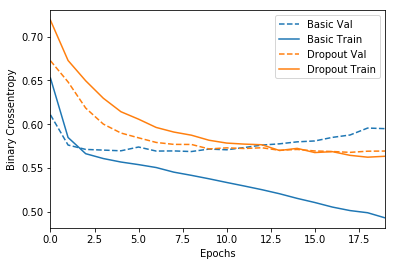

In [2]:
#[Drop out]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 20000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# 메모리 효율을 위해 데이터 중 data_num개만 사용합니다.
train_data = train_data[:data_num,:]
test_data = test_data[:data_num,:]
train_labels = train_labels[:data_num]
test_labels =test_labels[:data_num]

# 드롭 아웃을 적용한 모델과 비교하기 위해 기본 모델을 하나 만들어줍니다.

basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 각 Layer에 Dropout이 적용된 모델을 만들어보세요.
dropout_model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(word_num,)),
    # Dense (Fully Connected) Layer에 드롭 아웃을 적용해보세요.
    keras.layers.Dropout(0.5), #노드 0.5만 남긴다
    keras.layers.Dense(64, activation=tf.nn.relu),
    # Dense (Fully Connected) Layer에 드롭 아웃을 적용해보세요.
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
dropout_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
dropout_model.summary()
# Drop out이 적용된 모델을 학습시킵니다.
dropout_history = dropout_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('Dropout', dropout_history)])

## L1 Regularization
 
L1 Regularization은 가중치 (Weight)의 절댓값에 비례하는 Loss가 기존 손실 함수에 추가되는 형태.
 
L1 Regularization은 모델 내의 일부 가중치를 0으로 만들어 의미있는 가중치만 남도록 만들어줌. 이를 통해 모델을 일반화시킬 수 있다. 다른 말로 **Sparse Model을 만든다** 라고도 한다.
 
L1 Regularization을 모델에 적용하기 위해 *kernel.layers.Dense()* 내부에 인자로 *keras.regularizers.l1(ratio)* 을 추가할 수 있다.
 
---
L1 Regularization -keras.regularizers.l1(ratio) - ratio : L1을 적용하는 비율 (0.001 ~0.005)

•keras.layers.Dense(kernel_regularizer, bias_regularizer, activity_regularizer)  
    •kernel_regularizer : Weight에 Regularization 적용
    •bias_regularizer : Bias에 Regularization 적용
    •activity_regularizer : Output y에 Regularization 적용
  
---
•관련 링크 https://www.tensorflow.org/beta/tutorials/keras/overfit_and_underfit https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense
  
---

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6206 - accuracy: 0.6515 - binary_crossentropy: 0.6206 - val_loss: 0.5780 - val_accuracy: 0.6956 - val_binary_crossentropy: 0.5780
Epoch 2/20
25000/25000 - 0s - loss: 0.5682 - accuracy: 0.7029 - binary_crossentropy: 0.5682 - val_loss: 0.5680 - val_accuracy: 0.7025 - val_binary_crossentropy: 0

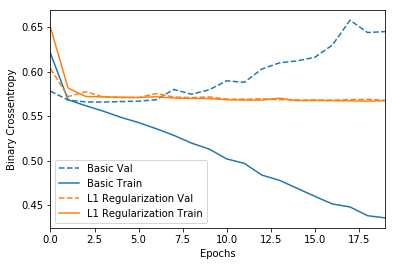

In [7]:
#[15-4]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])


# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# L1 Regularization 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델에 L1 Regularization을 적용해보겠습니다.
L1_regularization_model = keras.Sequential([
    # 각 Dense (Fully Connected) Layer에 인자로 keras.regularizers.l1을 적용해보세요.
    # Kernel, bias, activity에 하나씩 적용해보며 결과를 비교해보세요.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,), kernel_regularizer= keras.regularizers.l1(0.001),bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= keras.regularizers.l1(0.001),bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dense(1, activation=tf.nn.sigmoid,activity_regularizer=keras.regularizers.l1(0.001))
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

# L1 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
L1_regularization_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# L1 모델이 어떻게 이루어져있는지 출력합니다.
L1_regularization_model.summary()
# L1 모델을 학습시킵니다.
L1_regularization_history = L1_regularization_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('L1 Regularization', L1_regularization_history)])
              


---

## L2 Regularization
 
L2 Regularization은 가중치 (Weight)의 제곱에 비례하는 Loss가 기존 손실 함수에 추가되는 형태이다.

L2 Regularization은 학습이 진행될 때 가중치의 값이 **0에 가까워지도록** 만들어준다. 가중치를 0으로 만들어주는 L1 Regularization와는 차이가 있다.
 
이를 통해 특정 가중치에 치중되지 않도록 가중치 값을 조율하게 되며 **Weight Decay** 라고도 부른다.
 
L1 Regularization과 같이 kernel.layers.Dense() 내부에 인자로keras.regularizers.l2(ratio)을 추가할 수 있다.

---
L2 Regularization -keras.regularizers.l2(ratio) - ratio : L2을 적용하는 비율 (0.001 ~0.005)<br>

  • keras.layers.Dense(kernel_regularizer, bias_regularizer, activity_regularizer)<br>
  
` • kernel_regularizer : Weight에 Regularization 적용<br>
 `• bias_regularizer : Bias에 Regularization 적용<br>
  • activity_regularizer : Output y에 Regularization 적용<br>
  
--- 
  
  •관련 링크 https://www.tensorflow.org/beta/tutorials/keras/overfit_and_underfit https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense
  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6235 - accuracy: 0.6450 - binary_crossentropy: 0.6235 - val_loss: 0.5786 - val_accuracy: 0.6945 - val_binary_crossentropy: 0.5786
Epoch 2/20
25000/25000 - 0s - loss: 0.5699 - accuracy: 0.7040 - binary_crossentropy: 0.5699 - val_loss: 0.5726 - val_accuracy: 0.7015 - val_binary_crossentropy: 0

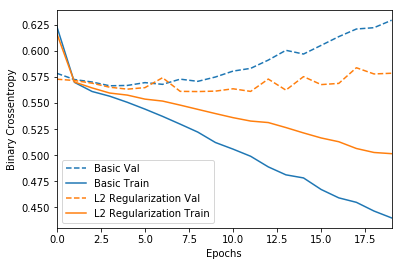

In [6]:
#[L2 Regularization]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])


# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# L2 Regularization 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델에 L2 Regularization을 적용해보겠습니다.
L2_regularization_model = keras.Sequential([
    # 각 Dense (Fully Connected) Layer에 인자로 keras.regularizers.l1을 적용해보세요.
    # Kernel, bias, activity에 하나씩 적용해보며 결과를 비교해보세요.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,), kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

# L2 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
L2_regularization_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', 'binary_crossentropy'])
# L2 모델이 어떻게 이루어져있는지 출력합니다.
L2_regularization_model.summary()
# L2 모델을 학습시킵니다.
L2_regularization_history = L2_regularization_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('L2 Regularization', L2_regularization_history)])
              
